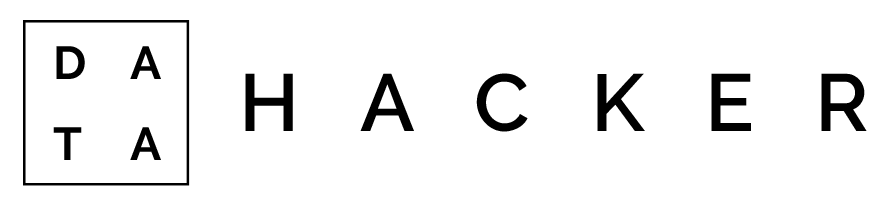
# Siamese Networks

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [66]:
from pathlib import Path
import requests
import zipfile
from PIL import Image
import matplotlib.patches as patches


In [67]:
data_path = Path("true_image")
image_path = data_path/'train'
image_path

WindowsPath('true_image/train')

In [70]:
import cv2
detector = cv2.CascadeClassifier("haar.xml")

In [69]:
!pip install opencv-python==3.4.11.43


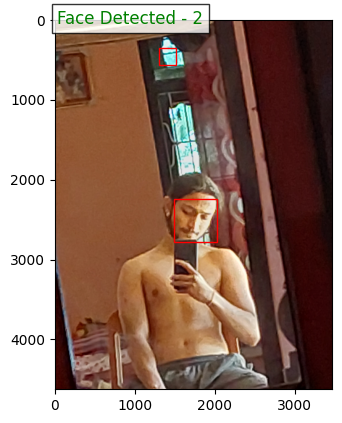

In [71]:
#HAAR CASCADE CLASSIFIER USE
IMAGE_LIST = list(data_path.glob("*/*/*.JPG"))
random_image = random.choice(IMAGE_LIST)
# Image.open(random_image)
frame = cv2.imread(str(random_image))
# frame = cv2.imread("5.jpeg")


gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faceRects = detector.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

# # loop over the faces and draw a rectangle around each
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# Loop over the faces and draw a rectangle around each
for (x, y, w, h) in faceRects:
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
no_of_face = len(faceRects)
plt.text(30, 50, f"Face Detected - {no_of_face}", fontsize=12, color='g', bbox=dict(facecolor='white', alpha=0.8))

# Display the plot
plt.show()


In [28]:
for path in sorted(list(image_path.glob("*/*.JPG"))):
    
	frame = cv2.imread(path)

	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	
	faceRects = detector.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

	# loop over the faces and draw a rectangle around each
	for (x, y, w, h) in faceRects:
		cv2.rectangle(frame, (x, y), (x + w, y + h), (255,0, 0), 3)
	
	no_of_face = len(faceRects)

	cv2.putText(frame, "Face Detected -  "+str(no_of_face), (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)	
	cv2_imshow(frame)
     

TypeError: Can't convert object to 'str' for 'filename'

In [72]:
# data_path = Path("ANUJ_ACHYUT/")
# image_path = data_path / "main_collection"

# # If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#     print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)
    
#     # Download pizza, steak, sushi data
#     with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#         request = requests.get("https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip")
#         print("Downloading images for siamese...")
#         f.write(request.content)

#     # Unzip pizza, steak, sushi data
#     with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#         print("Unzipping pizza, steak, sushi data...") 
#         zip_ref.extractall(image_path)

In [73]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [74]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [75]:
# Load the training dataset
# folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
folder_dataset = datasets.ImageFolder(root=image_path)
folder_dataset


Dataset ImageFolder
    Number of datapoints: 80
    Root location: true_image\train

In [76]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
siamese_dataset

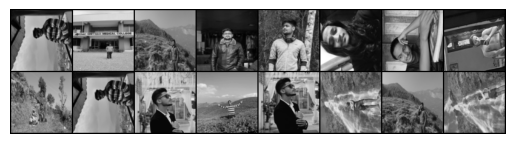

[1. 1. 1. 1. 1. 0. 1. 0.]


In [83]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

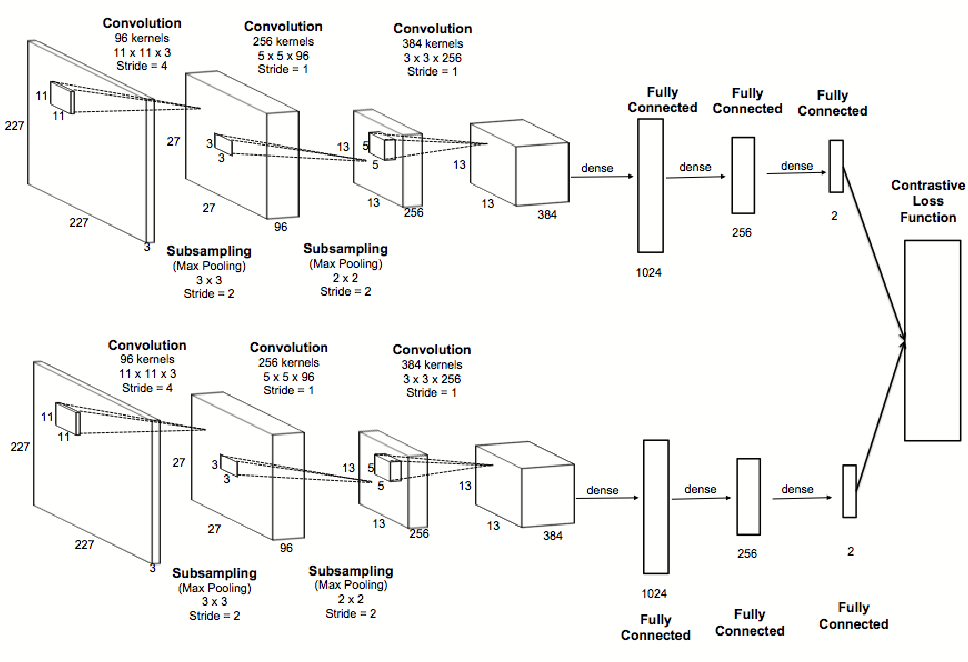

In [77]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

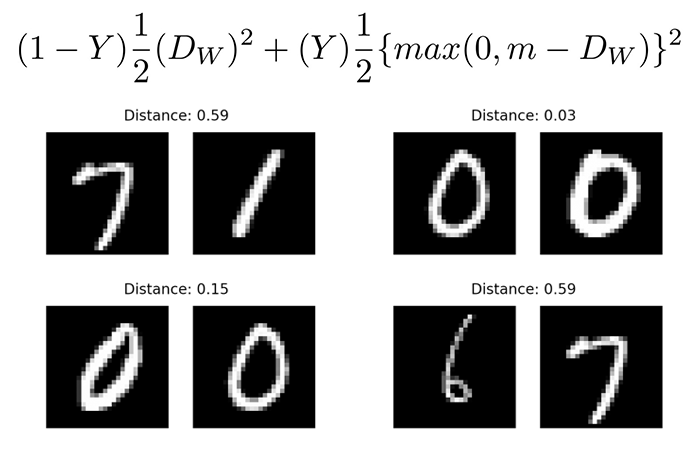

In [78]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [79]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=64)

In [80]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

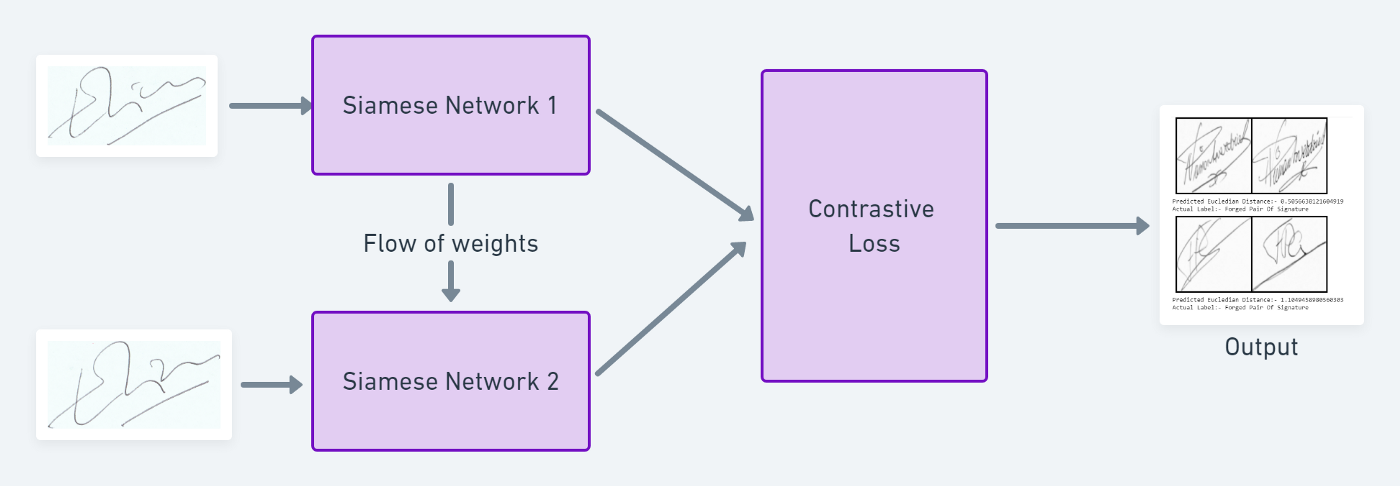

Epoch number 0
 Current loss 1.9331059455871582

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv-python-3.4.11.43.tar.gz (87.4 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [2030 lines of output]
      Ignoring numpy: markers 'python_version == "3.5"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7"' don't match your environment
        Using cached setuptools-69.0.3-py3-none-any.whl.metadata (6.3 kB)
        Using cached wheel-0.42.0-py3-none-any.whl.metadata (2.2 kB)
        Using cached scikit_build-0.17.6-py3-none-any.whl.metadata (14 kB)
        Using cached cmake-3.28.1-py2.py3-none-win_amd64.whl.metadata (6.5 kB)
        Using cached pip-23.3.2-py3-none-any.whl.metadata (3.5 kB)
        Using cached numpy-1.17.3.zip (6.4 MB)
        Preparing metadata (setup.py): started
        Preparing metadata (setup.py): finished with status 'done'
        Using cached distro-1.9.0-py3-none-any.whl.metadat

Epoch number 1
 Current loss 1.6072185039520264

Epoch number 2
 Current loss 1.7425119876861572

Epoch number 3
 Current loss 1.4404138326644897

Epoch number 4
 Current loss 1.1077991724014282

Epoch number 5
 Current loss 1.4148859977722168

Epoch number 6
 Current loss 1.5856198072433472

Epoch number 7
 Current loss 1.7771276235580444

Epoch number 8
 Current loss 1.4256951808929443

Epoch number 9
 Current loss 0.9629875421524048



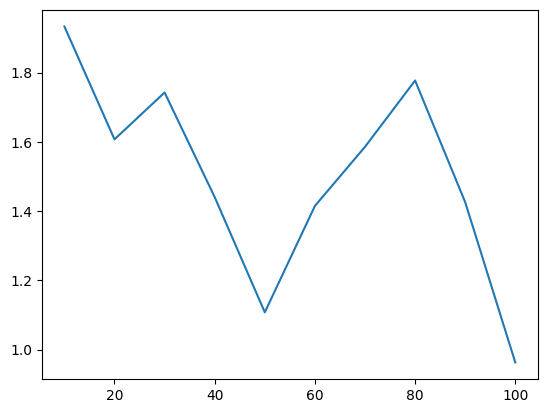

In [81]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(10):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

torch.Size([1, 1, 100, 100])


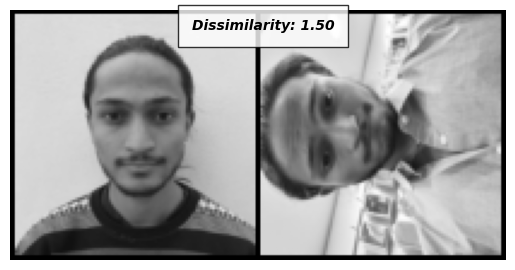

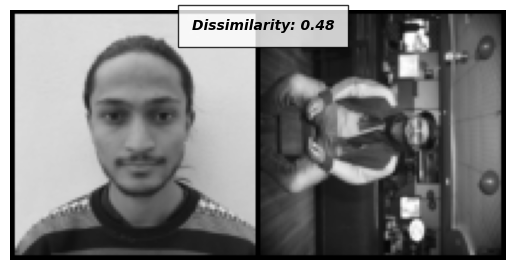

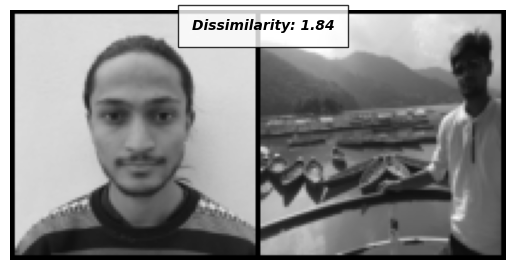

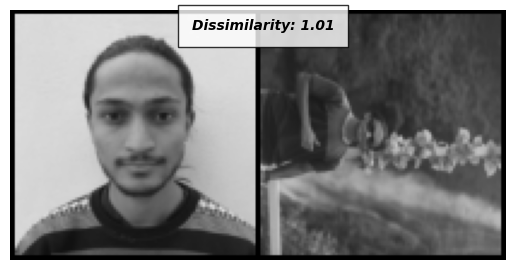

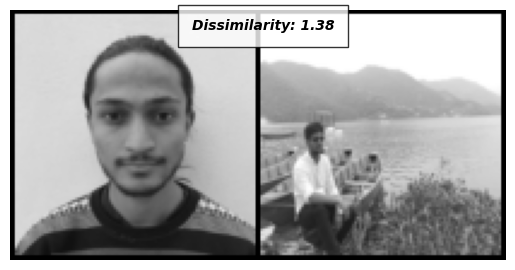

In [123]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root=data_path/'test')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
# x0, _, _ = next(dataiter)
# print(x0.shape)
x2=(cv2.imread("5.jpeg"))
#convert to gray scale
x2_gray = cv2.cvtColor(x2, cv2.COLOR_BGR2GRAY)
# Convert NumPy array to PIL Image
x2_pil = Image.fromarray(x2_gray)
#finally to tensors and same dimension of the test_dir
x2 = transformation(x2_pil).unsqueeze(dim=0)
print(x2.shape)

for i in range(5):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x2, x1), 0)

    output1, output2 = net(x2.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
     
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')